In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# Use the MPS device if available on your MacBook with Apple Silicon, otherwise fallback to CPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# Understanding Burgers' Equation

In this notebook, we explore Burgers' equation, a fundamental nonlinear partial differential equation used in fluid mechanics and nonlinear wave propagation. Its one-dimensional form is

$$
\frac{\partial u}{\partial t} + u\,\frac{\partial u}{\partial x} = \nu\,\frac{\partial^2 u}{\partial x^2},
$$
where:
- $ u(x,t) $ is the velocity field,
- $\nu$ is the viscosity.

We will:
- Discuss the equation and its physical meaning,
- Set up a numerical finite difference method to solve it,
- Visualize the solution in time.

## Numerical Approach

To solve Burgers' equation numerically, we discretize the spatial domain and time using finite differences. For a domain $ x \in [-1, 1] $ and time $ t \ge 0 $:

- **Spatial derivatives:**
  - $u_x$ is approximated with a central difference:
    $$
    u_x \approx \frac{u_{i+1} - u_{i-1}}{2\Delta x}
    $$
  - $ u_{xx} $ is approximated with a second-order central difference:
    $$
    u_{xx} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2}
    $$
- **Time derivative:**
  - We use an explicit forward Euler method:
    $$
    u_i^{n+1} = u_i^n + \Delta t\,\Big[-u_i^n \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} + \nu\,\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{(\Delta x)^2}\Big]
    $$

Boundary conditions (e.g., $ u(-1,t)=0 $ and $ u(1,t)=0 $) and an initial condition (for example, $ u(x,0)=-\sin(\pi x) $) are applied.



In [2]:
# Set up the simulation parameters and spatial grid
nx = 101               # number of spatial grid points
x = np.linspace(-1, 1, nx)
dx = x[1] - x[0]       # spatial step size

nt = 500               # number of time steps
dt = 0.001             # time step size

nu = 0.01 / np.pi      # viscosity parameter

print(f"dx = {dx:.5f}, dt = {dt}, viscosity = {nu:.5f}")


dx = 0.02000, dt = 0.001, viscosity = 0.00318


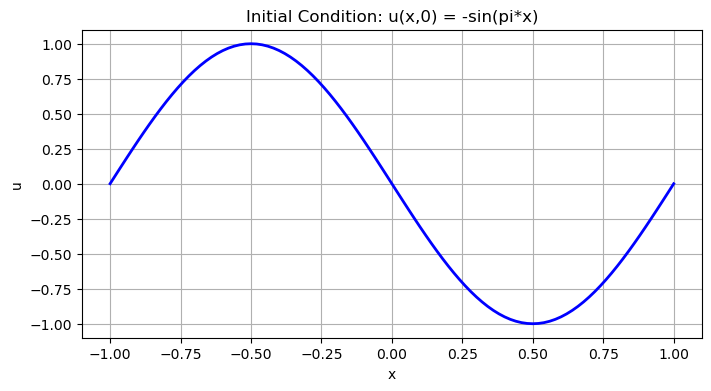

In [3]:
# Set the initial condition: u(x, 0) = -sin(pi * x)
u0 = -np.sin(np.pi * x)
u = u0.copy()  # make a copy for time stepping

# Plot the initial condition
plt.figure(figsize=(8, 4))
plt.plot(x, u, 'b-', lw=2)
plt.xlabel('x')
plt.ylabel('u')
plt.title("Initial Condition: u(x,0) = -sin(pi*x)")
plt.grid(True)
plt.show()


In [4]:
def step(u, dt, dx, nu):
    """
    Advance the solution u by one time step using a finite difference scheme.
    u: current solution (1D array)
    dt: time step
    dx: spatial step
    nu: viscosity coefficient
    Returns:
      u_new: updated solution after one time step
    """
    u_new = u.copy()
    # Use central differences for interior points
    for i in range(1, len(u)-1):
        # First derivative u_x
        u_x = (u[i+1] - u[i-1]) / (2 * dx)
        # Second derivative u_xx
        u_xx = (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)
        # Time stepping update
        u_new[i] = u[i] + dt * (-u[i] * u_x + nu * u_xx)
    # Enforce Dirichlet boundary conditions: u(-1,t)=0 and u(1,t)=0
    u_new[0] = 0
    u_new[-1] = 0
    return u_new


Time integration complete. Number of snapshots: 51


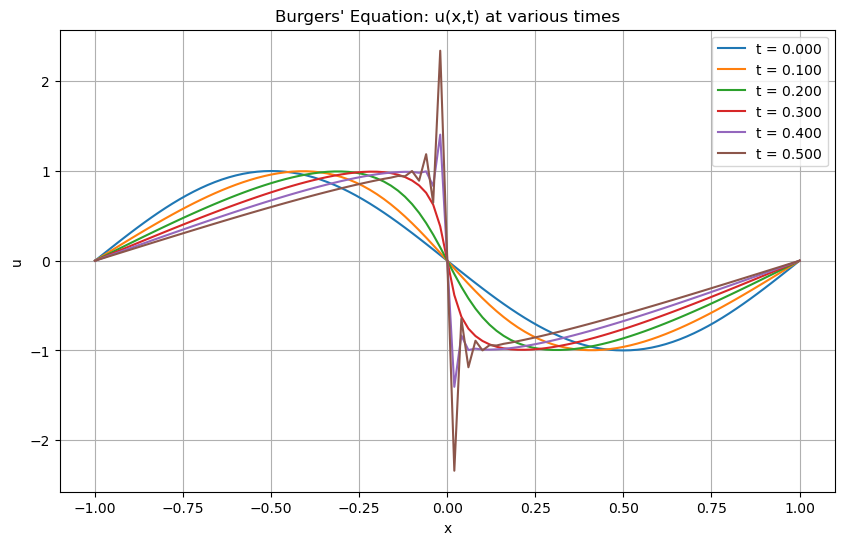

In [5]:
u = u0.copy()

# Time integration loop: evolve the solution and store snapshots for visualization
snapshots = []         # to store solution snapshots
snapshots.append(u.copy())

for n in range(nt):
    u = step(u, dt, dx, nu)
    # Save snapshot every 10 time steps
    if n % 10 == 0:
        snapshots.append(u.copy())

# Convert list of snapshots to a numpy array for easier handling
snapshots = np.array(snapshots)
print("Time integration complete. Number of snapshots:", snapshots.shape[0])

# Plot the solution at several time instants
plt.figure(figsize=(10, 6))
time_indices = np.linspace(0, snapshots.shape[0]-1, 6, dtype=int)
for idx in time_indices:
    plt.plot(x, snapshots[idx, :], label=f"t = {idx*10*dt:.3f}")
plt.xlabel('x')
plt.ylabel('u')
plt.title("Burgers' Equation: u(x,t) at various times")
plt.legend()
plt.grid(True)
plt.show()

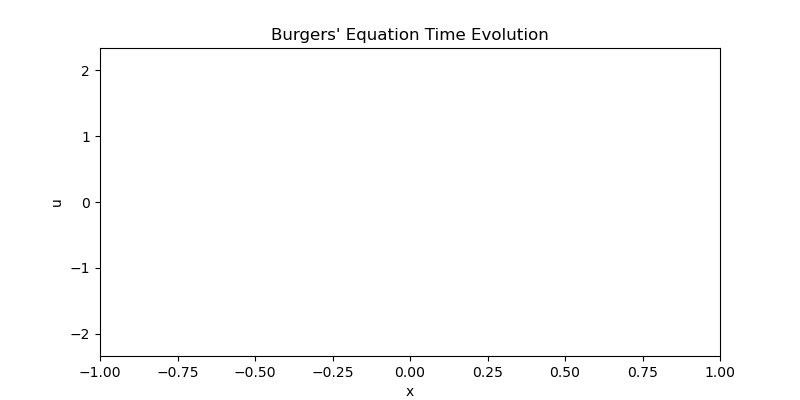

Animation saved as burgers_animation.gif


In [6]:
%matplotlib ipympl

# Create an animation of the solution evolution
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot([], [], 'b-', lw=2)
ax.set_xlim(-1, 1)
ax.set_ylim(np.min(snapshots), np.max(snapshots))
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title("Burgers' Equation Time Evolution")

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, snapshots[i, :])
    ax.set_title(f"t = {i*10*dt:.3f}")
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=snapshots.shape[0],
                               interval=50, blit=True)

plt.show()

from matplotlib.animation import PillowWriter

# Create a PillowWriter instance with desired frames per second (fps)
writer = PillowWriter(fps=20)

# Save the animation as a GIF file
anim.save("burgers_animation.gif", writer=writer)
print("Animation saved as burgers_animation.gif")


## Introduction to Physics-Informed Neural Networks (PINNs)

Physics-Informed Neural Networks (PINNs) offer an alternative approach to solving partial differential equations (PDEs). Instead of relying solely on discretized numerical schemes (like finite differences), PINNs embed the underlying physics into the loss function of a neural network. 

For Burgers' equation:
$$ u_t + u\, u_x = \nu\, u_{xx}, $$
a PINN is trained to:
- Satisfy the initial condition (e.g., $$ u(x,0) = -\sin(\pi x) $$),
- Enforce the boundary conditions (e.g., $$ u(-1,t) = u(1,t) = 0 $$),
- Minimize the residual of the PDE itself using automatic differentiation.

In the following cells, we will set up a PINN using PyTorch, train it to solve Burgers’ equation, and visualize its solution.

In [7]:
# Set the viscosity parameter for Burgers' equation
nu = 0.01 / np.pi

# Define the fully-connected neural network (PINN)
class PINN(nn.Module):
    def __init__(self, layers):
        """
        layers: List containing the number of neurons per layer.
                For example, [2, 20, 20, 20, 20, 1] means an input layer with 2 neurons,
                4 hidden layers with 20 neurons each, and an output layer with 1 neuron.
        """
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers)-1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
    
    def forward(self, x):
        # Pass data through each layer with a tanh activation (except final layer)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Define the network architecture
layers = [2, 20, 20, 20, 20, 1]
model = PINN(layers).to(device)

In [9]:
def pde_residual(model, x, t):
    """
    Computes the residual of Burgers' equation:
    $$ f = u_t + u, u_x - nu, u_{xx}, $$
    using automatic differentiation.

    Inputs:
      x, t: Tensors with requires_grad=True.
    """
    # Concatenate x and t to form the input
    inputs = torch.cat([x, t], dim=1)
    u = model(inputs)
    
    # Compute first derivatives with respect to x and t
    grad_u = torch.autograd.grad(u, inputs, 
                                 grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_t = grad_u[:, 1:2]
    
    # Compute second derivative with respect to x (u_xx)
    u_xx = torch.autograd.grad(u_x, x, 
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    
    # Burgers' equation residual: u_t + u*u_x - nu*u_xx
    f = u_t + u * u_x - nu * u_xx
    return f

def loss_function(model, x0, t0, u0, xb, tb, xf, tf_):
    """
    Computes the total loss as the sum of:
    - Initial condition loss: discrepancy at t=0,
    - Boundary condition loss: discrepancy at x=-1 and x=1,
    - PDE residual loss: discrepancy in the PDE at collocation points.
    """
    # Initial condition loss: u(x,0) should equal u0
    u0_pred = model(torch.cat([x0, t0], dim=1))
    loss_ic = torch.mean((u0 - u0_pred)**2)
    
    # Boundary condition loss: enforce u(-1,t)=0 and u(1,t)=0
    ub_pred = model(torch.cat([xb, tb], dim=1))
    loss_bc = torch.mean(ub_pred**2)
    
    # PDE residual loss: enforce f(x,t)=0 at collocation points
    xf.requires_grad = True
    tf_.requires_grad = True
    f_pred = pde_residual(model, xf, tf_)
    loss_pde = torch.mean(f_pred**2)
    
    return loss_ic + loss_bc + loss_pde

In [10]:
# Number of training points for each component
N0 = 100      # Initial condition points (t = 0)
Nb = 100      # Boundary condition points (x = -1 and 1)
Nf = 10000    # Collocation points for the PDE

# Initial condition: u(x,0) = -sin(pi*x) for x in [-1,1]
x0 = np.linspace(-1, 1, N0)[:, None]
t0 = np.zeros_like(x0)
u0 = -np.sin(np.pi * x0)

# Boundary conditions: u(-1,t)=0 and u(1,t)=0 for t in [0,1]
tb = np.linspace(0, 1, Nb)[:, None]
xb_left = -np.ones_like(tb)
xb_right = np.ones_like(tb)
xb = np.vstack([xb_left, xb_right])
tb = np.vstack([tb, tb])

# Collocation points: randomly sample in the domain [-1,1] x [0,1]
xf = np.random.uniform(-1, 1, (Nf, 1))
tf_ = np.random.uniform(0, 1, (Nf, 1))

# Convert the data to torch tensors and move to the selected device
x0_tensor = torch.tensor(x0, dtype=torch.float32, device=device)
t0_tensor = torch.tensor(t0, dtype=torch.float32, device=device)
u0_tensor = torch.tensor(u0, dtype=torch.float32, device=device)

xb_tensor = torch.tensor(xb, dtype=torch.float32, device=device)
tb_tensor = torch.tensor(tb, dtype=torch.float32, device=device)

xf_tensor = torch.tensor(xf, dtype=torch.float32, device=device)
tf_tensor = torch.tensor(tf_, dtype=torch.float32, device=device)


In [11]:
# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x0_tensor, t0_tensor, u0_tensor,
                         xb_tensor, tb_tensor, xf_tensor, tf_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.692087
Epoch 1000: Loss = 0.086140
Epoch 2000: Loss = 0.014414
Epoch 3000: Loss = 0.005729
Epoch 4000: Loss = 0.003622
Epoch 5000: Loss = 0.002911
Epoch 6000: Loss = 0.002356
Epoch 7000: Loss = 0.001584
Epoch 8000: Loss = 0.001421
Epoch 9000: Loss = 0.001256


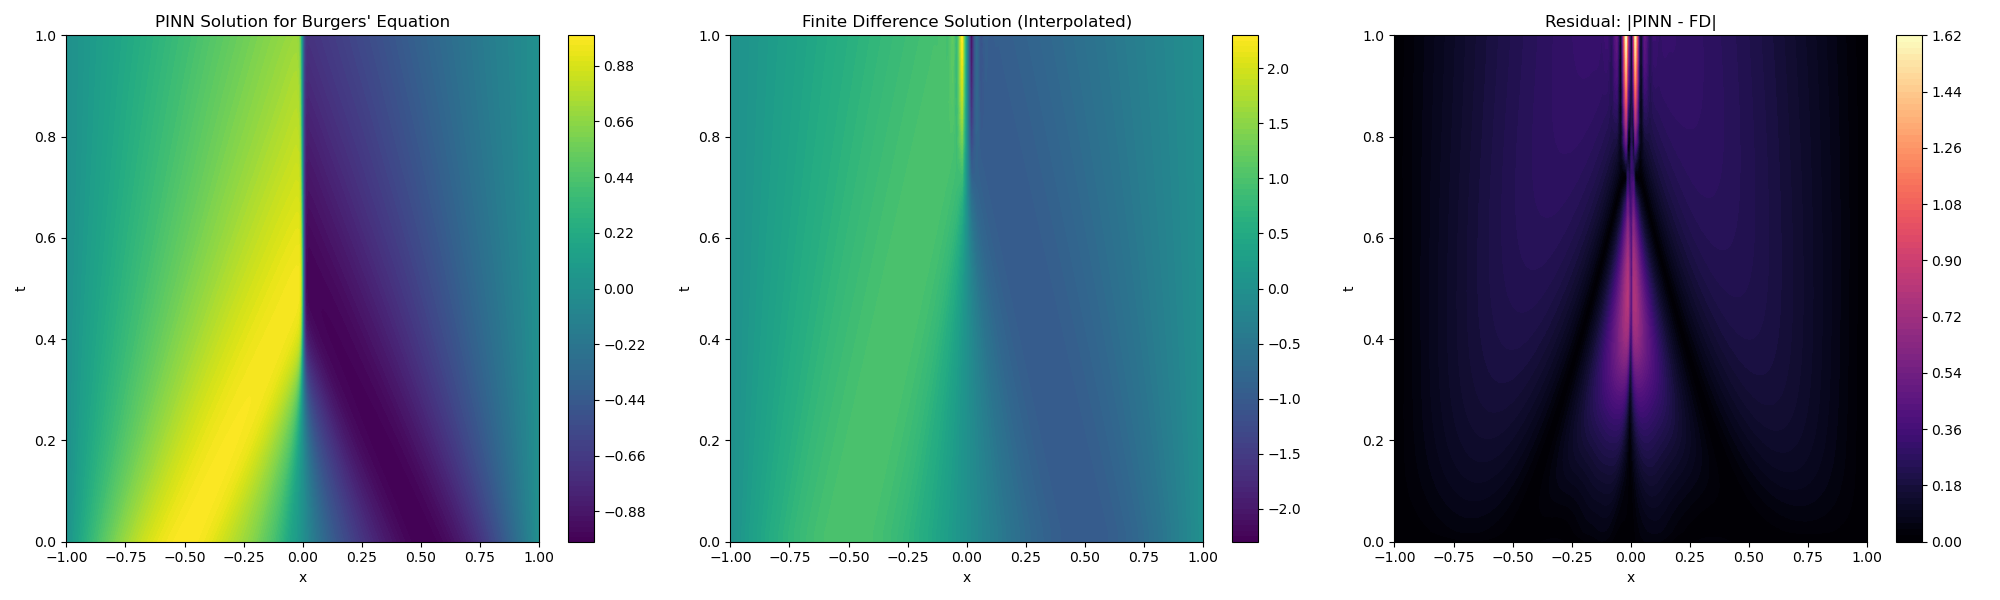

In [24]:
from scipy.interpolate import griddata

# --- Evaluate PINN Solution on a Grid ---
x_test = np.linspace(-1, 1, 256)
t_test = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_test, t_test)

# Convert grid points to tensors for the PINN model evaluation
X_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32, device=device)
T_flat = torch.tensor(T.flatten()[:, None], dtype=torch.float32, device=device)

with torch.no_grad():
    u_pred_pinn = model(torch.cat([X_flat, T_flat], dim=1))
u_pred_pinn = u_pred_pinn.cpu().numpy().reshape(T.shape)

# --- Prepare Finite Difference (FD) Data ---
# Assume snapshots_burgers is a NumPy array with shape (n_snapshots, nx)
n_snapshots, nx = snapshots.shape
# Create the FD time grid (assumed to cover t in [0,1])
t_fd = np.linspace(0, 1, n_snapshots)
# The spatial grid from the FD simulation is stored in 'x'
X_fd, T_fd = np.meshgrid(x, t_fd)

# Interpolate the FD solution onto the (x_test, t_test) grid using griddata
points_fd = np.vstack([X_fd.flatten(), T_fd.flatten()]).T
values_fd = snapshots.flatten()
u_fd_interp = griddata(points_fd, values_fd, (X, T), method='linear')

# --- Compute the Residual ---
residual = np.abs(u_pred_pinn - u_fd_interp)

# --- Create Side-by-Side Plots ---
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# PINN Solution Plot
c1 = axs[0].contourf(X, T, u_pred_pinn, 100, cmap='viridis')
axs[0].set_title("PINN Solution for Burgers' Equation")
axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
fig.colorbar(c1, ax=axs[0])

# Finite Difference (FD) Solution Plot (Interpolated)
c2 = axs[1].contourf(X, T, u_fd_interp, 100, cmap='viridis')
axs[1].set_title("Finite Difference Solution (Interpolated)")
axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
fig.colorbar(c2, ax=axs[1])

# Residual Plot: Absolute difference between PINN and FD solutions
c3 = axs[2].contourf(X, T, residual, 100, cmap='magma')
axs[2].set_title("Residual: |PINN - FD|")
axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()


## Comparison with the Finite Difference Solution

If you have previously computed a finite difference solution for Burgers' equation (for example, stored in the variable `snapshots` with spatial grid `x`), you can compare it with the PINN solution.

Below is an example of how you might compare the two at the final time ($t=1$):

- Plot the finite difference solution at $t=1$.
- Plot the PINN solution at $t=1$.
- Overlay them to see how well the PINN approximates the traditional numerical solution.


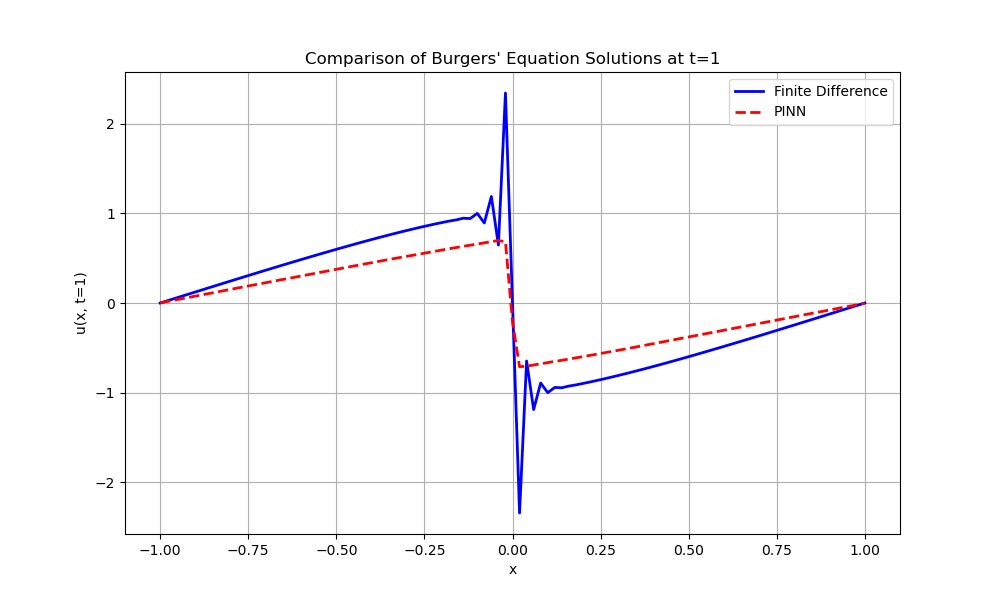

In [22]:
# Assuming you have finite difference data:
# - `snapshots`: a numpy array with the solution at different times (rows) and spatial grid x (columns).
# - `x`: the spatial grid corresponding to the finite difference solution.

# For example, take the final time step from the finite difference solution:
u_fd = snapshots[-1, :]
t_fd = 1.0  # final time

# For the PINN, evaluate the solution at t = 1 for the same spatial grid:
x_test_fd = torch.tensor(x.reshape(-1, 1), dtype=torch.float32, device=device)
t_test_fd = torch.full_like(x_test_fd, t_fd)
with torch.no_grad():
    u_pin = model(torch.cat([x_test_fd, t_test_fd], dim=1))
u_pin = u_pin.cpu().numpy().flatten()

# Plot both solutions for comparison
plt.figure(figsize=(10, 6))
plt.plot(x, u_fd, 'b-', lw=2, label='Finite Difference')
plt.plot(x, u_pin, 'r--', lw=2, label='PINN')
plt.xlabel('x')
plt.ylabel('u(x, t=1)')
plt.title("Comparison of Burgers' Equation Solutions at t=1")
plt.legend()
plt.grid(True)
plt.show()
